![A soccer pitch for an international match.](soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

In [85]:
# Start your code here!
import datetime
import pandas as pd
from scipy.stats import mannwhitneyu
import pingouin
import statsmodels.api as sm
import matplotlib.pyplot as plt

pd.options.display.width = 0
pd.options.display.max_colwidth = None

## Exploratory Data Analysis

In [86]:
df_men = pd.read_csv("./datasets/men_results.csv", index_col=0)
df_women = pd.read_csv("./datasets/women_results.csv", index_col=0)

df_men["datetime"] = pd.to_datetime(df_men["date"])
df_women["datetime"] = pd.to_datetime(df_women["date"])

print(df_men.dtypes)
print(df_women.dtypes)

date                  object
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
datetime      datetime64[ns]
dtype: object
date                  object
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
datetime      datetime64[ns]
dtype: object


In [87]:
df_men

,date,home_team,away_team,home_score,away_score,tournament,datetime
0,1872-11-30,Scotland,England,0,0,Friendly,1872-11-30
1,1873-03-08,England,Scotland,4,2,Friendly,1873-03-08
2,1874-03-07,Scotland,England,2,1,Friendly,1874-03-07
3,1875-03-06,England,Scotland,2,2,Friendly,1875-03-06
4,1876-03-04,Scotland,England,3,0,Friendly,1876-03-04
...,...,...,...,...,...,...,...
44348,2022-12-14,Thailand,Taiwan,0,1,Friendly,2022-12-14
44349,2022-12-14,Vietnam,Philippines,1,0,Friendly,2022-12-14
44350,2022-12-17,Croatia,Morocco,2,1,FIFA World Cup,2022-12-17
44351,2022-12-17,Singapore,Maldives,3,1,Friendly,2022-12-17


In [88]:
df_women

,date,home_team,away_team,home_score,away_score,tournament,datetime
0,1969-11-01,Italy,France,1,0,Euro,1969-11-01
1,1969-11-01,Denmark,England,4,3,Euro,1969-11-01
2,1969-11-02,England,France,2,0,Euro,1969-11-02
3,1969-11-02,Italy,Denmark,3,1,Euro,1969-11-02
4,1975-08-25,Thailand,Australia,3,2,AFC Championship,1975-08-25
...,...,...,...,...,...,...,...
4879,2022-07-22,Sweden,Belgium,1,0,UEFA Euro,2022-07-22
4880,2022-07-23,France,Netherlands,1,0,UEFA Euro,2022-07-23
4881,2022-07-26,England,Sweden,4,0,UEFA Euro,2022-07-26
4882,2022-07-27,Germany,France,2,1,UEFA Euro,2022-07-27


## Filtering the Data

In [89]:
filter_datetime = datetime.datetime(2002, 1, 1)
df_men_2021 = df_men[(df_men["datetime"] >= filter_datetime) & (df_men["tournament"]=="FIFA World Cup")].copy()
df_women_2021 = df_women[(df_women["datetime"] >= filter_datetime) & (df_women["tournament"]=="FIFA World Cup")].copy()

df_men_2021["total"] =df_men_2021["home_score"] + df_men_2021["away_score"]
df_women_2021["total"] = df_women_2021["home_score"] + df_women_2021["away_score"]

## Choosing the Correct Hypothesis Test

### Normality Test

We will use Shapiro-Wilk Test for normality

$H_0$: The women's goals and men's come from normal distribution.
$H_A$: The women's goals and men's do not come from normal distribution.

In [90]:
women_shapiro_wilk = pingouin.normality(df_women_2021["total"])
women_shapiro_wilk

,W,pval,normal
total,0.849101,3.890520e-13,False


In [91]:
men_shapiro_wilk = pingouin.normality(df_men_2021["total"])
men_shapiro_wilk

,W,pval,normal
total,0.926649,8.894154e-13,False


In both cases of women's and men's matches we reject the null hypothesis that the distribution of total goals scored is normal since the p-value is very low

<Axes: >

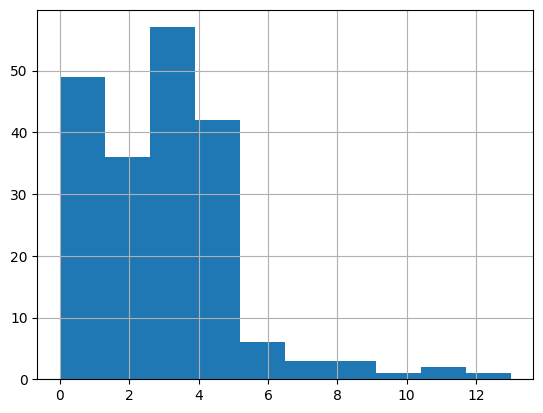

In [92]:
df_women_2021["total"].hist()

<Axes: >

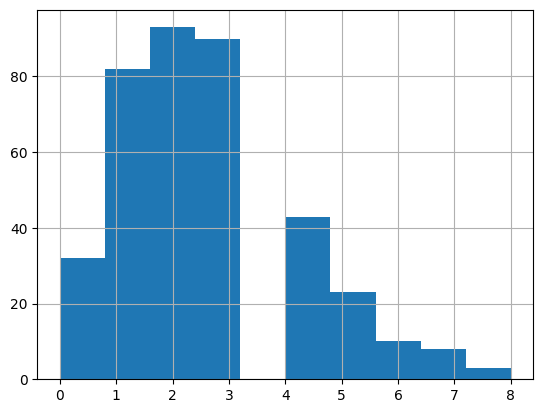

In [93]:
df_men_2021["total"].hist()

The histograms also show that the distributions of goals are not normal

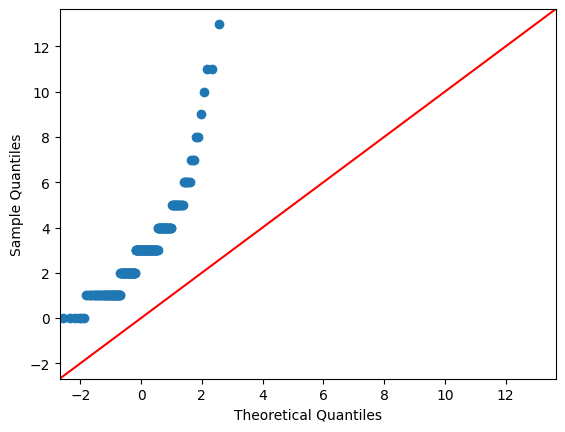

In [94]:
sm.qqplot(df_women_2021["total"], line='45')
plt.show()

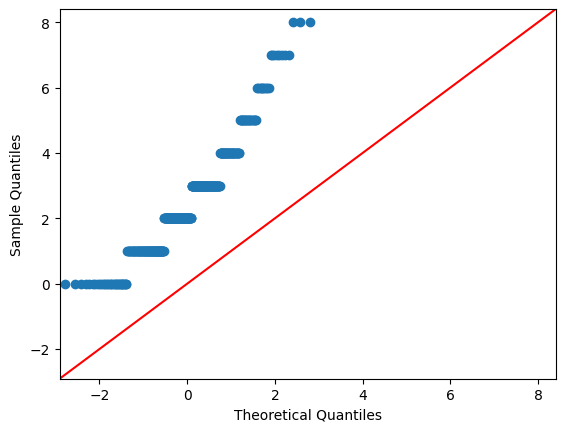

In [95]:
sm.qqplot(df_men_2021["total"], line='45')
plt.show()

The q-q plot shows that the data is not normal

In [69]:
alpha = 0.1

We will us Mann Whitney U-test in this case because:

- data is not normally distributed
- unpaired data

And the hypothesis is:

$H_0$: $\mu_{\text{women}} = \mu_{\text{men}}$
$H_A$: $\mu_{\text{women}} > \mu_{\text{men}}$

Also, we will be using right-tailed test

### Using ```scipy.stats``` library

In [100]:
mwu_scipy_test_results = mannwhitneyu(
    x=df_women_2021["total"],
    y=df_men_2021["total"],
    alternative="greater"
)

mwu_scipy_test_results

MannwhitneyuResult(statistic=43273.0, pvalue=0.005106609825443641)

### Using ```pingouin``` library

In [101]:
mwu_pingouin_test_results = pingouin.mwu(
    x=df_women_2021["total"],
    y=df_men_2021["total"],
    alternative="greater"
)
mwu_pingouin_test_results

,U-val,alternative,p-val,RBC,CLES
MWU,43273.0,greater,0.005107,-0.126901,0.563451


In [102]:
p_value = mwu_pingouin_test_results["p-val"].iloc[0]

In [103]:
result_dict = {
    "p_val": p_value,
    "result": "reject"
}

result_dict

{'p_val': 0.005106609825443641, 'result': 'reject'}

Since p_value < alpha, we reject the null hypothesis that mean number of goals in women soccer is same as those of men